Variable             Value
------------  ------------
Lo             1.10971e-12
Co_no_shunt    4.43883e-16
Le             1.06532e-12
Ce_no_shunt    4.62378e-16
Ca             4.62378e-16
Cm             4.53131e-16
Cst            3.09897e-15
Zo            50
Ze            48
eps_o_off(r)   5
eps_e_off(r)   5
eps_o_on(r)   39.9074
eps_e_on(r)    4.8
7325262130689.223


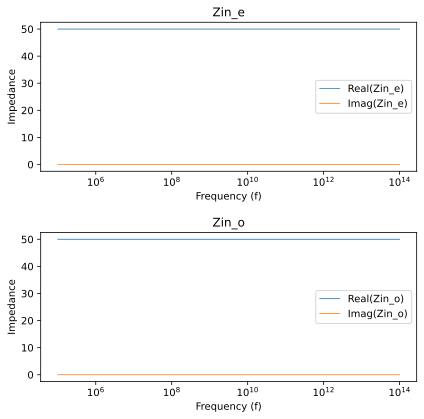

1856427294524.1714


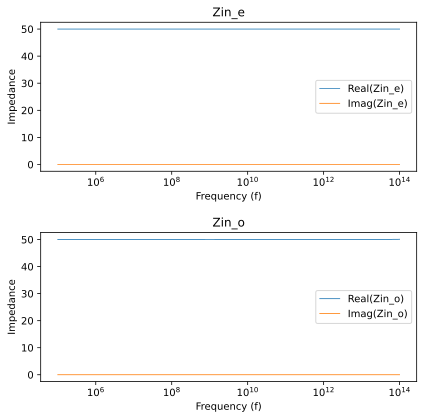

7325262130689.223
1856427294524.1714


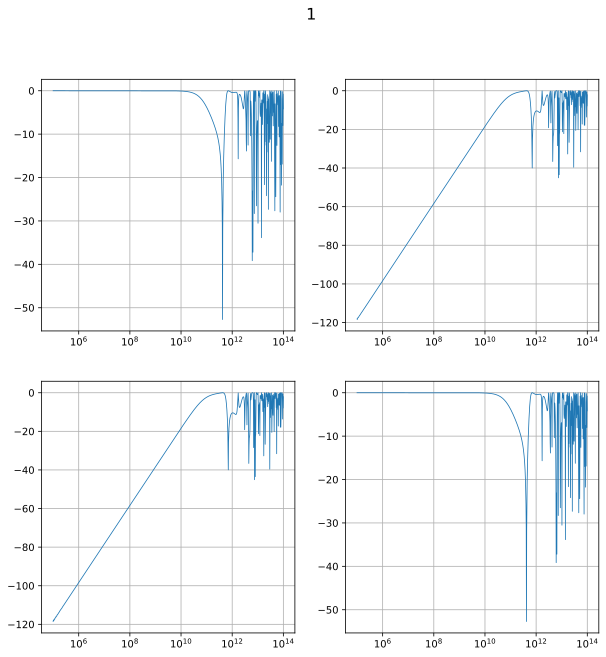

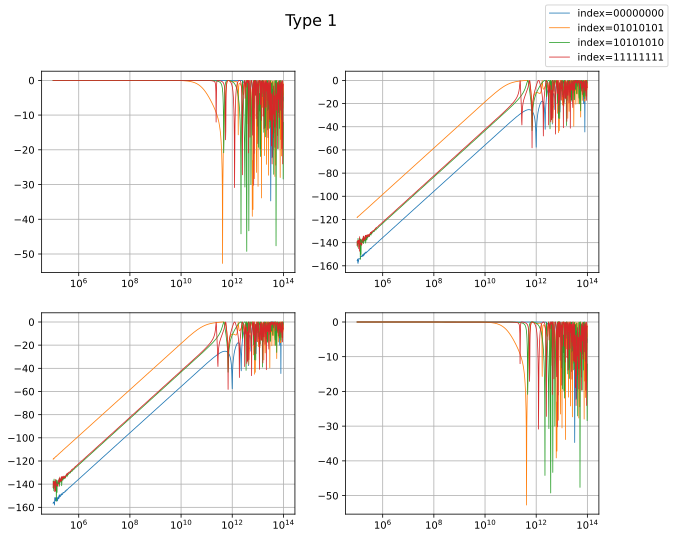

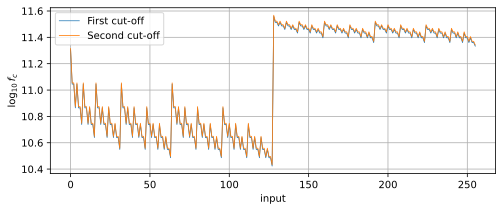

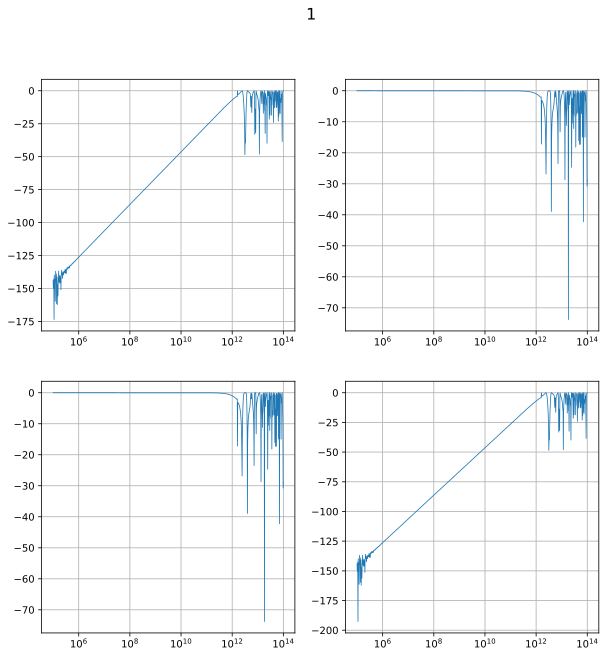

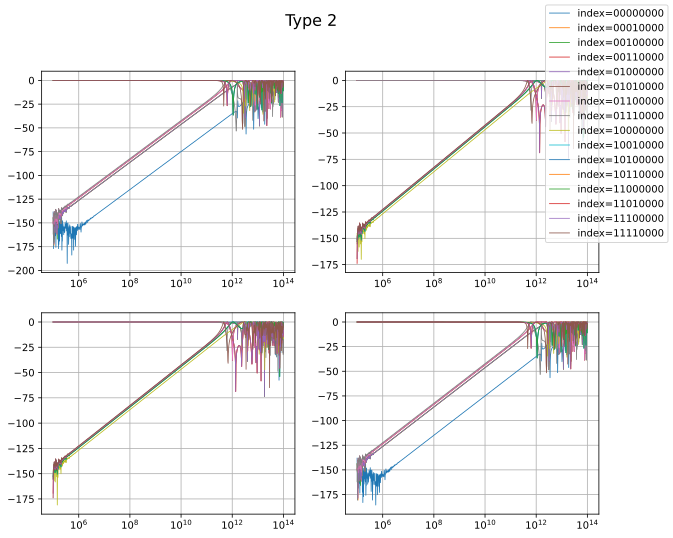

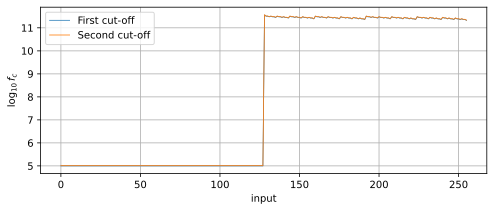

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import constants
import itertools
import pandas as pd
from tabulate import tabulate
from matplotlib.lines import Line2D


%config InlineBackend.figure_format = 'svg'
plt.rcParams['lines.linewidth'] = 0.8
## Constants
epsilon_0 = constants.epsilon_0

fstart = 5
fstop = 14
fpoints = 1000
f = np.logspace(fstart, fstop, fpoints)

l = 1e-5
S_storage1 = {}
S_storage2 = {}
S_storage3 = {}
S_storage4 = {}
## Prameters Setup
def Z_eff_2_L_C(Z0o, Z0e, eps_o, eps_e, L, T):
    c = constants.speed_of_light

    Lo = (Z0o/c)*np.sqrt(eps_o)
    Co_no_shunt = np.sqrt(eps_o)/(c*Z0o)

    Le = (Z0e/c)*np.sqrt(eps_e)
    Ce_no_shunt = np.sqrt(eps_e)/(c*Z0e)

    Ca = Ce_no_shunt
    Cm = (Co_no_shunt+Ce_no_shunt)/2

    Cst = (constants.epsilon_0*T)/(10e-5) # shunt capacitance

    return Lo, Co_no_shunt, Le, Ce_no_shunt, Ca, Cm, Cst

def L_C_2_Z_eff(Lo, Co_no_shunt, Le, Ce_no_shunt):
    c = constants.speed_of_light

    eps_o = (Co_no_shunt * Lo) * (c ** 2)
    Z0o = np.sqrt(Lo/Co_no_shunt)

    eps_e = (Ce_no_shunt * Le) * (c ** 2)
    Z0e = np.sqrt(Le/Ce_no_shunt)

    return Z0o, Z0e, eps_o/constants.epsilon_0, eps_e/constants.epsilon_0

## Matrix Algebra
def invert_mat(A):
    inv_A = np.zeros((len(A[0, :, 0]), len(A[:, 0, 0]), len(A[0, 0, :])), dtype=complex)
    for i in range(len(A[0, 0])):
        inv_A[:, :, i] = np.linalg.inv(A[:, :, i])

    return inv_A

def multiply_mat(A, B):
    C = np.zeros((len(A[0, :, 0]), len(A[:, 0, 0]), len(A[0, 0, :])), dtype=complex)
    for i in range(len(A[0, 0, :])):
        C[:, :, i] = A[:, :, i] @ B[:, :, i]

    return C
## Mode Extraction
def odd_mode_params(f, Lo, Cm, Ca, Gm, Ga, R):
    w = 2*np.pi*f
    Co = 2*Cm - Ca
    Go = 2*Gm + Ga
    Lo = Lo
    Ro = R
    #gamma_o = 1e-5 + 1j*(2*np.pi*w*np.sqrt(Lo*Co))
    gamma_o = np.sqrt( (1j*w*Lo + Ro)*(1j*w*(Co) + Go) )
    Z0o = np.sqrt((Ro+1j*w*Lo)/(Go + 1j*w*Co))


    f0_o = 1/(2*np.pi*np.sqrt(Lo*Co)) # frequency at which the coupled lines are a quarter-wavelength long electrically when excited in the odd mode
    print(f0_o)
    theta_o = (np.pi/2)*(f/f0_o)

    return Lo, Co, Go, Ro, gamma_o, Z0o, theta_o

def even_mode_params(f, Le, Cm, Ca, Gm, Ga, R):
    w = 2*np.pi*f
    Ce = Ca
    Ge = Ga
    Le = Le
    Re = R
    #gamma_e = 1e-4 + 1j*(2*np.pi*w*np.sqrt(Le*Ce))
    gamma_e = np.sqrt( (1j*w*Le + Re)*(1j*w*(Ce) + Ge) )
    Z0e = np.sqrt((Re+1j*w*Le)/(Ge + 1j*w*Ce))

    f0_e = 1/(2*np.pi*np.sqrt(Le*Ce)) #frequency at which the coupled lines are a quarter-wavelength long electrically when excited in the even mode,
    theta_e = (np.pi/2)*(f/f0_e)

    return Le, Ce, Ge, Re, gamma_e, Z0e, theta_e
## Z Matrix
def create_Z_matrix(Z0e, cot_theta_e, csc_theta_e, Z0o, cot_theta_o, csc_theta_o):

    Z11 = -(1j/2) * (Z0e*cot_theta_e + Z0o*cot_theta_o)
    Z12 = -(1j/2) * (Z0e*cot_theta_e - Z0o*cot_theta_o)
    Z13 = -(1j/2) * (Z0e*csc_theta_e - Z0o*csc_theta_o)
    Z14 = -(1j/2) * (Z0e*csc_theta_e + Z0o*csc_theta_o)

    Z = np.zeros((4, 4, len(Z11)), dtype=complex)

    Z[0][0][:] = Z11
    Z[1][1][:] = Z[0][0][:]
    Z[2][2][:] = Z[0][0][:]
    Z[3][3][:] = Z[0][0][:]

    Z[0][1][:] = Z12
    Z[1][0][:] = Z[0][1][:]
    Z[2][3][:] = Z[0][1][:]
    Z[3][2][:] = Z[0][1][:]

    Z[0][2][:] = Z13
    Z[2][0][:] = Z[0][2][:]
    Z[1][3][:] = Z[0][2][:]
    Z[3][1][:] = Z[0][2][:]

    Z[0][3][:] = Z14
    Z[3][0][:] = Z[0][3][:]
    Z[1][2][:] = Z[0][3][:]
    Z[2][1][:] = Z[0][3][:]

    return Z


## Z $\to$ S and S $\to$ Z
def create_F(Z01, Z02, Z03, Z04):
    F = np.zeros((4, 4, len(Z01)), dtype=complex)
    F[0][0][:] = 1/(2*np.sqrt(Z01))
    F[1][1][:] = 1/(2*np.sqrt(Z02))
    F[2][2][:] = 1/(2*np.sqrt(Z03))
    F[3][3][:] = 1/(2*np.sqrt(Z04))
    return F

def create_G(Z01, Z02, Z03, Z04):
    G = np.zeros((4, 4, len(Z01)), dtype=complex)
    G[0][0][:] = Z01
    G[1][1][:] = Z02
    G[2][2][:] = Z03
    G[3][3][:] = Z04
    return G

def create_reduced_F(f):
    F = np.zeros((2, 2, len(f)), dtype=complex)
    F[0][0][:] = 1/(2*np.sqrt(50))
    F[1][1][:] = 1/(2*np.sqrt(50))

    return F

def create_reduced_G(f):
    G = np.zeros((2, 2, len(f)), dtype=complex)
    G[0][0][:] = 50
    G[1][1][:] = 50

    return G

def z2s(Z, F, G):

    # Calculate Z - G* and Z + G
    Z_minus_G_star = Z - np.conj(G)
    Z_plus_G = Z + G

    # Calculate the inverse of Z + G
    Z_plus_G_inv = invert_mat(Z_plus_G)

    # Calculate F^(-1)
    F_inv = invert_mat(F)

    # Calculate S = F(Z - G*)(Z + G)^(-1)F^(-1)
    S = multiply_mat(multiply_mat(F, Z_minus_G_star), multiply_mat(Z_plus_G_inv, F_inv))

    return S

def s2z(S, F, G):
    # Calculate the identity matrix I of the same shape as S
    I = np.zeros(S.shape, dtype=complex)
    for i in range(S.shape[2]):
        I[:, :, i] = np.eye(4, dtype=complex)

    # Calculate (I - S)^(-1)
    I_minus_S_inv = invert_mat(I - S)

    # Calculate SG + G*
    SG_plus_G_star = multiply_mat(S, G) + np.conj(G)

    # Calculate F^(-1)
    F_inv = invert_mat(F)

    # Calculate Z = F^(-1)(I - S)^(-1)(SG + G*)F
    Z = multiply_mat(multiply_mat(F_inv, I_minus_S_inv), multiply_mat(SG_plus_G_star, F))

    return Z
## ABCD Matrices
def s2abcd(S, Z0):
    ABCD = np.zeros((2, 2, len(f)), dtype=complex)
    S11 = S[0, 0, :]
    S12 = S[0, 1, :]
    S21 = S[1, 0, :]
    S22 = S[1, 1, :]
    ABCD[0, 0, : ] = ( (1+S11)*(1-S22) + S12*S21 )/( 2*S21 )
    ABCD[0, 1, :] = Z0* ( (1+S11)*(1+S22) - S12*S21 )/( 2*S21 )
    ABCD[1, 0, :] = (1/Z0) * ( (1+S11)*(1+S22) - S12*S21 )/( 2*S21 )
    ABCD[1, 1, :] = ( (1-S11)*(1+S22) + S12*S21 )/( 2*S21 )

    return ABCD

def plot_ABCD(f, A, B, C, D):
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 10))
    ax.flat[0].semilogx(f, np.abs(A))
    ax.flat[0].set_xlabel("f")
    ax.flat[0].set_ylabel("$20 \cdot \log_{10}(A)$")
    ax.flat[0].grid(True)  # Add grid lines

    ax.flat[1].semilogx(f, np.abs(B))
    ax.flat[1].set_xlabel("f")
    ax.flat[1].set_ylabel("$20 \cdot \log_{10}(B)$")
    ax.flat[1].grid(True)  # Add grid lines

    ax.flat[2].semilogx(f, np.abs(C))
    ax.flat[2].set_xlabel("f")
    ax.flat[2].set_ylabel("$20 \cdot \log_{10}(C)$")
    ax.flat[2].grid(True)  # Add grid lines

    ax.flat[3].semilogx(f, np.abs(D))
    ax.flat[3].set_xlabel("f")
    ax.flat[3].set_ylabel("$20 \cdot \log_{10}(D)$")
    ax.flat[3].grid(True)  # Add grid lines

    plt.show()
## $\epsilon_{eff}$
def s2eps_eff(f, S, Z0, L):
    ABCD = s2abcd(S, Z0)
    beta = np.imag((1/L) * np.arccosh((ABCD[0, 0, : ] + ABCD[1, 1, :])/2))
    return ( (beta*constants.speed_of_light)/(2*np.pi*f) )**2
## Create S Matrix for 4 port Switch on-off
def create_S_off(f, Lo, Co_no_shunt, Le, Ce_no_shunt, Ca, Gm, Ga, R):
    Lo, Co, Go, Ro, gamma_o, Z0o, theta_o = odd_mode_params(f, Lo, Co_no_shunt, Ca, Gm, Ga, R)
    Le, Ce, Ge, Re, gamma_e, Z0e, theta_e = even_mode_params(f, Le, Ce_no_shunt, Ca, Gm, Ga, R)

    cot_theta_o = 1/np.tan(theta_o)
    cot_theta_e = 1/np.tan(theta_e)

    csc_theta_o = 1/np.sin(theta_o)
    csc_theta_e = 1/np.sin(theta_e)

    Z = create_Z_matrix(Z0e, cot_theta_e, csc_theta_e, Z0o, cot_theta_o, csc_theta_o)

    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    return z2s(Z, F, G) # convert to S parameters for cascading

def create_S_on(f, Lo, Co_plus_shunt, Le, Ce_plus_shunt, Ca, Gm, Ga, R):
    Lo, Co, Go, Ro, gamma_o, Z0o, theta_o = odd_mode_params(f, Lo, Co_plus_shunt, Ca, Gm, Ga, R)
    Le, Ce, Ge, Re, gamma_e, Z0e, theta_e = even_mode_params(f, Le, Ce_plus_shunt, Ca, Gm, Ga, R)

    cot_theta_o = 1/np.tan(theta_o)
    cot_theta_e = 1/np.tan(theta_e)

    csc_theta_o = 1/np.sin(theta_o)
    csc_theta_e = 1/np.sin(theta_e)

    Z = create_Z_matrix(Z0e, cot_theta_e, csc_theta_e, Z0o, cot_theta_o, csc_theta_o)

    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    return z2s(Z, F, G) # convert to S parameters for cascading
## 2-Port Convertors
# V2 = 0 and I3 = 0 - reduces the matrix to that of a 2 port system

# Configuration 1: Ports 1 and 2 Retained (Ports 3 and 4 Eliminated)
def reduce_config1(Z):
    return Z[np.ix_([0, 1], [0, 1])]

# Configuration 2: Ports 1 and 3 Retained (Ports 2 and 4 Eliminated)
def reduce_config2(Z):
    return Z[np.ix_([0, 2], [0, 2])]

# Configuration 3: Ports 1 and 4 Retained (Ports 2 and 3 Eliminated)
def reduce_config3(Z):
    return Z[np.ix_([0, 3], [0, 3])]

# Configuration 4: Ports 2 and 3 Retained (Ports 1 and 4 Eliminated)
def reduce_config4(Z):
    return Z[np.ix_([1, 2], [1, 2])]



def convert_final_S_to_2_port_S_config_1(S):
    # update F and G
    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    Z = s2z(S, F, G)
    Z_lpf = reduce_config1(Z)
    return z2s(Z_lpf, create_reduced_F(f), create_reduced_G(f))

def convert_final_S_to_2_port_S_config_2(S):
    # update F and G
    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    Z = s2z(S, F, G)
    Z_bpf = reduce_config1(Z)
    return z2s(Z_bpf, create_reduced_F(f), create_reduced_G(f))

def convert_final_S_to_2_port_S_config_3(S):
    # update F and G
    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    Z = s2z(S, F, G)
    Z_bpf = reduce_config3(Z)
    return z2s(Z_bpf, create_reduced_F(f), create_reduced_G(f))


def convert_final_S_to_2_port_S_config_4(S):
    # update F and G
    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    Z = s2z(S, F, G)
    Z_bpf = reduce_config4(Z)
    return z2s(Z_bpf, create_reduced_F(f), create_reduced_G(f))
## Trying all Combinations
def find_final_S_params_1(S_on, S_off, input):
    for i in range(len(input)):
        if (i == 0 and input[i] == 0):
            S = S_off
        if (i == 0 and input[i] == 1):
            S = S_on
        else:
            if (input[i] == 0):
                S = multiply_mat(S, S_off)
            else:
                S = multiply_mat(S, S_on)
    return convert_final_S_to_2_port_S_config_1(S)

def find_final_S_params_2(S_on, S_off, input):
    for i in range(len(input)):
        if (i == 0 and input[i] == 0):
            S = S_off
        if (i == 0 and input[i] == 1):
            S = S_on
        else:
            if (input[i] == 0):
                S = multiply_mat(S, S_off)
            else:
                S = multiply_mat(S, S_on)
    return convert_final_S_to_2_port_S_config_2(S)

def find_final_S_params_3(S_on, S_off, input):
    for i in range(len(input)):
        if (i == 0 and input[i] == 0):
            S = S_off
        if (i == 0 and input[i] == 1):
            S = S_on
        else:
            if (input[i] == 0):
                S = multiply_mat(S, S_off)
            else:
                S = multiply_mat(S, S_on)
    return convert_final_S_to_2_port_S_config_3(S)

def find_final_S_params_4(S_on, S_off, input):
    for i in range(len(input)):
        if (i == 0 and input[i] == 0):
            S = S_off
        if (i == 0 and input[i] == 1):
            S = S_on
        else:
            if (input[i] == 0):
                S = multiply_mat(S, S_off)
            else:
                S = multiply_mat(S, S_on)
    return convert_final_S_to_2_port_S_config_4(S)

def all_possible_S_params(S_on, S_off, input_matrix, S_storage, config):
    if (config == 1):
        for i in range(len(input_matrix[:, 0])):
            S_storage[i] = find_final_S_params_1(S_on, S_off, input_matrix[i, :])
    if (config == 2):
        for i in range(len(input_matrix[:, 0])):
            S_storage[i] = find_final_S_params_2(S_on, S_off, input_matrix[i, :])
    if (config == 3):
        for i in range(len(input_matrix[:, 0])):
            S_storage[i] = find_final_S_params_3(S_on, S_off, input_matrix[i, :])
    if (config == 4):
        for i in range(len(input_matrix[:, 0])):
            S_storage[i] = find_final_S_params_4(S_on, S_off, input_matrix[i, :])
## Plot
def plot_S_params(f, S, title):
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 10))
    for i in range(4):
        ax.flat[i].semilogx(f, 20*np.log10(np.abs(S[int(i/2), i%2, :])))
        ax.flat[i].grid(True)  # Add grid lines
    # Set a common title for all subplots
    fig_S_params.suptitle(title, fontsize=16)
    plt.show()

def plot_full_S_params(f, S, title):
    gridSize = int(np.ceil(np.sqrt(16)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(15, 15))
    for i in range(16):
        ax.flat[i].semilogx(f, 20*np.log10(np.abs(S[int(i/4), i%4, :])))
        ax.flat[i].grid(True)  # Add grid lines
    # Set a common title for all subplots
    fig_S_params.suptitle(title, fontsize=16)
    plt.show()

'''def plot_all_possible_S_params(f, S_storage, title, n):
    N = len(S_storage)
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 8))

    # Create a list of legend entries
    legend_entries = []
    for j in range(0, N, int(N/n)):
        legend_entries.append(f"index={format(j, f'0{8}b')}")

    # Add a legend to each subplot
    for i in range(4):
        for j in range(0, N, int(N/n)):
            line, = ax.flat[i].semilogx(f, 20*np.log10(np.abs(S_storage[j][int(i/2), i%2, :])))
        ax.flat[i].grid(True)  # Add grid lines

    # Set a common title for all subplots
    fig_S_params.suptitle(title, fontsize=16)
    fig_S_params.legend(legend_entries)
    plt.show()'''


def moving_average(data, window_size):
    """Calculate the moving average of a 1D array."""
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size



def plot_all_possible_S_params(f, S_storage, title, n, smooth_window=1):
    N = len(S_storage)
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 8))

    # Create a list of legend entries
    legend_entries = []
    for j in range(0, N, int(N/n)):
        legend_entries.append(f"index={format(j, f'0{8}b')}")

    # Add a legend to each subplot
    for i in range(4):
        for j in range(0, N, int(N/n)):
            # Smooth the S-parameter data
            smoothed_S = moving_average(20*np.log10(np.abs(S_storage[j][int(i/2), i%2, :])), smooth_window)
            line, = ax.flat[i].semilogx(f[:len(smoothed_S)], smoothed_S)
        ax.flat[i].grid(True)  # Add grid lines

    # Set a common title for all subplots
    fig_S_params.suptitle(title, fontsize=16)
    fig_S_params.legend(legend_entries)
    plt.show()
## Input Impedance
def find_Zin(ZL, Zc, gamma, l):
    return Zc * ( (ZL + 1j*Zc*np.tan(gamma*l))/(Zc + 1j*ZL*np.tan(gamma*l)) )

def plot_off_even_Z_in(f, Z0o, Z0e, gamma_o, gamma_e, l):

    Zin_o = find_Zin(50*np.ones(len(f)), Z0o, gamma_o, l)
    Zin_e = find_Zin(50*np.ones(len(f)), Z0e, gamma_e, l)
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

    # Plot real and imaginary parts of Zin_e
    ax1.semilogx(f, np.real(Zin_e), label='Real(Zin_e)')
    ax1.semilogx(f, np.imag(Zin_e), label='Imag(Zin_e)')
    ax1.set_xlabel('Frequency (f)')
    ax1.set_ylabel('Impedance')
    ax1.set_title('Zin_e')
    ax1.legend()

    # Plot real and imaginary parts of Zin_o
    ax2.semilogx(f, np.real(Zin_o), label='Real(Zin_o)')
    ax2.semilogx(f, np.imag(Zin_o), label='Imag(Zin_o)')
    ax2.set_xlabel('Frequency (f)')
    ax2.set_ylabel('Impedance')
    ax2.set_title('Zin_o')
    ax2.legend()

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()
## Checking cut-offs
def find_cutoff_frequency(frequencies, s11_values, threshold=0.708):
    """
    Find the first cutoff frequency in the S11 vs. frequency plot.

    Parameters:
    - frequencies: An array of frequency values.
    - s11_values: An array of S11 values corresponding to the frequencies.
    - threshold: The threshold value to determine the cutoff point (default is 0.1).

    Returns:
    - cutoff_frequency: The first cutoff frequency found.
    """
    # Find the index where S11 first drops below the threshold
    below_threshold_indices = np.where(s11_values < threshold)[0]

    if len(below_threshold_indices) > 0:
        # Get the index of the first occurrence
        cutoff_index = below_threshold_indices[0]
        cutoff_frequency = frequencies[cutoff_index]
        return cutoff_frequency
    else:
        # If no cutoff point is found, return None
        return None

import numpy as np

def find_cutoff_frequencies(frequencies, s11_values, threshold=-3.0):
    """
    Find the first and second cutoff frequencies at -3 dB in the S11 vs. frequency plot.

    Parameters:
    - frequencies: An array of frequency values.
    - s11_values: An array of S11 values corresponding to the frequencies.
    - threshold: The threshold value (-3 dB by default).

    Returns:
    - cutoff_freq_1: The first cutoff frequency found at -3 dB.
    - cutoff_freq_2: The second cutoff frequency found at -3 dB.
    """
    # Convert threshold from dB to linear scale
    threshold_linear = 10 ** (threshold / 20)

    # Initialize variables to store the first and second cutoff frequencies
    cutoff_freq_1 = None
    cutoff_freq_2 = None

    for i in range(len(frequencies)):
        if s11_values[i] < threshold_linear:
            if cutoff_freq_1 is None:
                cutoff_freq_1 = frequencies[i]
            elif cutoff_freq_2 is None:
                cutoff_freq_2 = frequencies[i]
                break  # Stop searching after finding the second cutoff

    return cutoff_freq_1, cutoff_freq_2



def fc_finder(f, S_storage):
    fc_storage1 = np.zeros(len(S_storage))
    fc_storage2 = np.zeros(len(S_storage))
    for i in range(len(S_storage)):
        fc_storage1[i], fc_storage2[i] = find_cutoff_frequencies(f, S_storage[i][0, 0, :])
    return fc_storage1, fc_storage2

def plot_cut_offs(f, S_storage):
    plt.figure(figsize=(8, 3))
    x = np.arange(len(S_storage))
    fc_storage1, fc_storage2 = fc_finder(f, S_storage)
    plt.plot(x, np.log10(fc_storage1))
    plt.plot(x, np.log10(fc_storage2))

    plt.xlabel("input")
    plt.ylabel("$\log_{10}f_c$")
    plt.grid()
    plt.show()
def main():
    Lo, Co_no_shunt, Le, Ce_no_shunt, Ca, Cm, Cst = Z_eff_2_L_C(50, 48, 5*epsilon_0, 5*epsilon_0, l, 0.035e-6)
    R = 1e-10
    Gm = 1e-20
    Ga = 1e-20

    # Create a list of tuples containing variable names and their values
    variables = [
        ("Lo", Lo),
        ("Co_no_shunt", Co_no_shunt),
        ("Le", Le),
        ("Ce_no_shunt", Ce_no_shunt),
        ("Ca", Ca),
        ("Cm", Cm),
        ("Cst", Cst),
        ("Zo", np.sqrt(Lo/Co_no_shunt)),
        ("Ze", np.sqrt(Le/Ce_no_shunt)),
        ("eps_o_off(r)", constants.speed_of_light**2 * Lo * Co_no_shunt/constants.epsilon_0),
        ("eps_e_off(r)", constants.speed_of_light**2 * Le * Ce_no_shunt/constants.epsilon_0),
        ("eps_o_on(r)", constants.speed_of_light**2 * Lo * (Co_no_shunt + Cst)/constants.epsilon_0),
        ("eps_e_on(r)", constants.speed_of_light**2 * Le * (Co_no_shunt)/constants.epsilon_0)

    ]

    # Print the variables in a table
    print(tabulate(variables, headers=["Variable", "Value"]))

    Lo, Co, Go, Ro, gamma_o, Z0o, theta_o = odd_mode_params(f, Lo, Co_no_shunt, Ca, Gm, Ga, R)
    Le, Ce, Ge, Re, gamma_e, Z0e, theta_e = even_mode_params(f, Le, Ce_no_shunt, Ca, Gm, Ga, R)
    plot_off_even_Z_in(f, np.sqrt(Lo/Co), np.sqrt(Le/Ce), gamma_o, gamma_e, l)

    Lo, Co, Go, Ro, gamma_o, Z0o, theta_o = odd_mode_params(f, Lo, Co_no_shunt+Cst, Ca, Gm, Ga, R)
    Le, Ce, Ge, Re, gamma_e, Z0e, theta_e = even_mode_params(f, Le, Ce_no_shunt, Ca, Gm, Ga, R)
    plot_off_even_Z_in(f, np.sqrt(Lo/Co), np.sqrt(Le/Ce), gamma_o, gamma_e, l)

    num_of_sections = 8
    num_of_combinations = 2**num_of_sections

    # Generate all possible combinations of an 8-bit input
    input_combinations = list(itertools.product([0, 1], repeat=num_of_sections))

    # Convert the combinations to a NumPy array
    input_matrix = np.array(input_combinations)

    C_odd = input_matrix*(Co_no_shunt+Cst) + (1-input_matrix)*Co_no_shunt # capacitance values for every single state
    C_even = input_matrix*(Ce_no_shunt) + (1-input_matrix)*Ce_no_shunt # capacitance values for every single state

    # simulate for swicth off
    S_off = create_S_off(f, Lo, Co_no_shunt, Le, Ce_no_shunt, Ca, Gm, Ga, R)

    # simulate for switch on
    S_on = create_S_off(f, Lo, Co_no_shunt + Cst, Le, Ce_no_shunt + Cst, Ca, Gm, Ga, R)

    all_possible_S_params(S_on=S_on, S_off=S_off, input_matrix=input_matrix, S_storage=S_storage1, config=1)
    all_possible_S_params(S_on=S_on, S_off=S_off, input_matrix=input_matrix, S_storage=S_storage2, config=2)
    all_possible_S_params(S_on=S_on, S_off=S_off, input_matrix=input_matrix, S_storage=S_storage3, config=3)
    all_possible_S_params(S_on=S_on, S_off=S_off, input_matrix=input_matrix, S_storage=S_storage4, config=4)
if __name__ == "__main__":
    main()
plot_S_params(f, S_storage1[90], "1")
plot_all_possible_S_params(f, S_storage1, "Type 1", 3)
plot_cut_offs(f, S_storage1)
plot_S_params(f, S_storage4[4], "1")
plot_all_possible_S_params(f, S_storage4, "Type 2", 16)
plot_cut_offs(f, S_storage4)